700-hPa Relative Humidity
=========================

Classic 700-hPa Map that displays Relative Humidity

By: Kevin Goebbert

This example uses GFS output to displays common 700-hPa parameters
including relative humidity.

Import needed modules


In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
import xarray as xr

Access data using Xarray


In [2]:
ds = xr.open_dataset('https://thredds.ucar.edu/thredds/dodsC/casestudies/'
                     'python-gallery/GFS_20101026_1200.nc').metpy.parse_cf()

# Fix units on Relative Humidity
ds.Relative_humidity_isobaric.attrs['units'] = 'percent'

Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Could not find variable corresponding to the value of grid_mapping: LatLon_Proje

Data Parsing
------------

Parse out desired data and attach units.

Smooth using MetPy’s ``smooth_gaussian`` function to minimize noise in
output.


In [3]:
# Set subset slice for the geographic extent of data to limit download
lon_slice = slice(200, 350)
lat_slice = slice(85, 10)

# Grab lat/lon values (GFS will be 1D)
lats = ds.lat.sel(lat=lat_slice).values
lons = ds.lon.sel(lon=lon_slice).values

# Select specific level data
level = 700 * units.hPa
hght_700 = mpcalc.smooth_gaussian(ds['Geopotential_height_isobaric'].metpy.sel(
    vertical=level, lon=lon_slice, lat=lat_slice).squeeze(), 2)
tmpk_700 = mpcalc.smooth_gaussian(ds['Temperature_isobaric'].metpy.sel(
    vertical=level, lon=lon_slice, lat=lat_slice).squeeze(), 2)
uwnd_700 = mpcalc.smooth_gaussian(ds['u-component_of_wind_isobaric'].metpy.sel(
    vertical=level, lon=lon_slice, lat=lat_slice).squeeze(), 2)
vwnd_700 = mpcalc.smooth_gaussian(ds['v-component_of_wind_isobaric'].metpy.sel(
    vertical=level, lon=lon_slice, lat=lat_slice).squeeze(), 2)
relh_700 = mpcalc.smooth_gaussian(ds['Relative_humidity_isobaric'].metpy.sel(
    vertical=level, lon=lon_slice, lat=lat_slice).squeeze(), 2)

# Convert temperature to Celsius for plotting purposes
tmpc_700 = tmpk_700.to('degC')

# Get times in nice datetime format
vtime = ds.time.data.squeeze().astype('datetime64[ms]').astype('O')

Plot Data
---------

Use Cartopy to plot 700-hPa data on a Lambert Conformal Map and
colorfill the relative humidity


Text(1.0, 1.0, 'Valid Time: 2010-10-26 12:00:00')

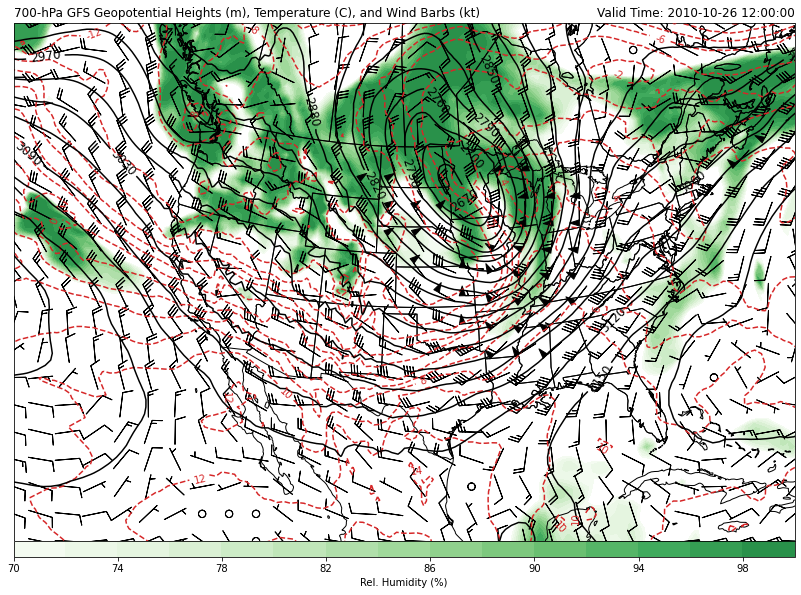

In [4]:
# Set graphic projection
mapcrs = ccrs.LambertConformal(central_longitude=-100, central_latitude=35,
                               standard_parallels=(30, 60))

# Set data projection
datacrs = ccrs.PlateCarree()

# Begin figure and set CONUS areal extent
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add coastlines and state boundaries
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot Colorfill of 700-hPa relative humidity -
# normalize color to not have too dark of green at the top end
clevs_700_relh = np.arange(70, 101, 2)
cf = ax.contourf(lons, lats, relh_700, clevs_700_relh, cmap=plt.cm.Greens,
                 norm=plt.Normalize(70, 110), transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)
cb.set_label('Rel. Humidity (%)')

# Plot contours of 700-hPa temperature in Celsius in red, dashed lines
clevs_700_tmpc = np.arange(-40, 41, 2)
cs1 = ax.contour(lons, lats, tmpc_700, clevs_700_tmpc, colors='tab:red',
                 linestyles='dashed', transform=datacrs)
ax.clabel(cs1, fmt='%d')

# Plot contours of 700-hPa geopotential height in black, solid lines
clevs_700_hght = np.arange(0, 8000, 30)
cs2 = ax.contour(lons, lats, hght_700, clevs_700_hght, colors='black', transform=datacrs)
ax.clabel(cs2, fmt='%d', fontsize='large')

# Plot 700-hPa wind barbs in knots
ax.barbs(lons, lats, uwnd_700.to('kt').m, vwnd_700.to('kt').m, pivot='middle',
         color='black', regrid_shape=20, transform=datacrs)

# Add some useful titles
plt.title('700-hPa GFS Geopotential Heights (m), Temperature (C),'
          ' and Wind Barbs (kt)', loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')